### To do

1. Explorar los datos de ejemplo de perros y gatos de kaggle
2. Construir y entrenar una red neuronal para reconocer la diferencia entre ellos
3. Evaluar la precisión de la formación y la validación

### Download dataset 
We started by downloading our sample data, a .zip of 2,000 JPG images of cats and dogs, and extracting it locally in `/tmp` format.

In [1]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2020-12-02 10:11:17--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolviendo storage.googleapis.com (storage.googleapis.com)... 172.217.172.16, 172.217.30.208, 216.58.222.208, ...
Conectando con storage.googleapis.com (storage.googleapis.com)[172.217.172.16]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 68606236 (65M) [application/zip]
Guardando como: “/tmp/cats_and_dogs_filtered.zip”

/tmp/cats_and_dogs_ 100%[===================>]  65,43M  8,52MB/s    en 7,5s    

2020-12-02 10:11:25 (8,78 MB/s) - “/tmp/cats_and_dogs_filtered.zip” guardado [68606236/68606236]



In [2]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

The training set is the data that is used to tell the neural network model that 'this is what a cat looks like', 'this is what a dog looks like' etc. The validation data set is images of cats and dogs that the neural network will not see as part of the training, so you can test how well or how badly it does in evaluating if an image contains a cat or a dog.

In [3]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train' )
validation_dir = os.path.join( base_dir, 'validation' )

#directory with training cat/dog pics
train_cats_dir = os.path.join( train_dir, 'cats' )
train_dogs_dir = os.path.join( train_dir, 'dogs' )


# Directory with  validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [4]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.554.jpg', 'cat.874.jpg', 'cat.720.jpg', 'cat.216.jpg', 'cat.583.jpg', 'cat.488.jpg', 'cat.196.jpg', 'cat.982.jpg', 'cat.159.jpg', 'cat.502.jpg']
['dog.282.jpg', 'dog.218.jpg', 'dog.615.jpg', 'dog.359.jpg', 'dog.251.jpg', 'dog.815.jpg', 'dog.263.jpg', 'dog.973.jpg', 'dog.156.jpg', 'dog.446.jpg']


In [5]:
print( 'total training cat imgs: ', len( os.listdir( train_cats_dir ) ))
print( 'total training dog imgs: ', len( os.listdir( train_dogs_dir ) ))

print( 'total validation cat imgs: ', len( os.listdir( validation_cats_dir ) ))
print( 'total validation dog imgs: ', len( os.listdir( validation_dogs_dir ) ))

total training cat imgs:  1000
total training dog imgs:  1000
total validation cat imgs:  500
total validation dog imgs:  500


In [7]:
#configure matplot parameters to plot


import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

Now, display a batch of 8 cat and 8 dog pictures

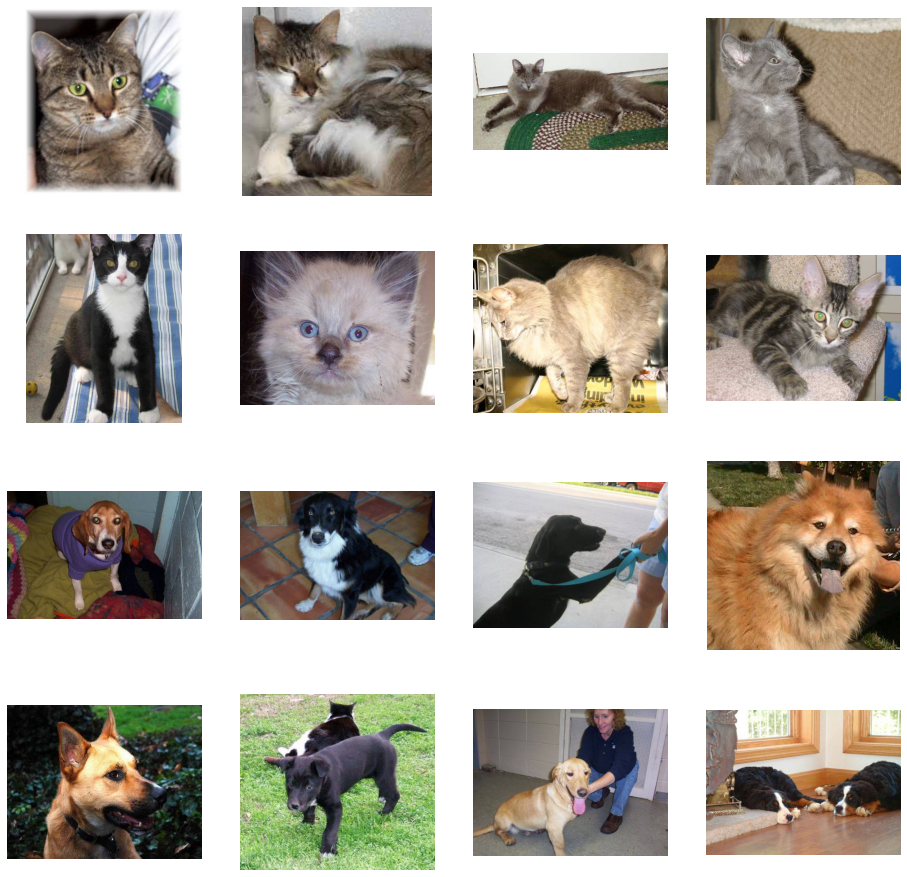

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


the next step is to define the model that will be trained to recognize cats or dogs from these images

### Building model 
1. import tensorflow
2. check gpu

In [9]:
import tensorflow as tf

add a couple of convolutional layers and flatten the final result to feed into the densely connected layers.

**Note** that because we are facing a two-class classification problem, i.e. a binary classification problem, we will end our network with a [***sigmoid activation***](https://en.wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a  scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [10]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

Configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [12]:
from tensorflow.keras.optimizers import RMSprop

model.compile( optimizer = RMSprop(lr= 0.001),
             loss= 'binary_crossentropy',
             metrics= ['accuracy'])

Texto original
setup data generators that will read pictures in our source folders, convert them to float32 tensors, and feed them (with their labels) to our network. 

We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

#All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale= 1.0/255. )
test_datagen = ImageDataGenerator( rescale= 1.0/255. )

#Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))   

#Flow training images in batches of 20 using train_datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))   


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Train the model

Let's train on all 2,000 images , for 15 epochs, and validate on all 1,000 test images. (This may take a few minutes.)
You'll see 4 values per epoch -- Loss, Accuracy, Validation Loss and Validation Accuracy. 

- The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result.  Accuracy is the portion of correct guesses. 
- The Validation accuracy is the measurement with the data that has not been used in training. As expected this would be a bit lower. You'll learn about why this occurs in the section on overfitting later in this course.

In [14]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=15,
                              validation_steps=50,
                              verbose=2)

Epoch 1/15
100/100 - 20s - loss: 0.8867 - accuracy: 0.5395 - val_loss: 0.6719 - val_accuracy: 0.6370
Epoch 2/15
100/100 - 19s - loss: 0.6526 - accuracy: 0.6595 - val_loss: 0.5907 - val_accuracy: 0.6670
Epoch 3/15
100/100 - 18s - loss: 0.5927 - accuracy: 0.6955 - val_loss: 0.5591 - val_accuracy: 0.7220
Epoch 4/15
100/100 - 17s - loss: 0.5080 - accuracy: 0.7490 - val_loss: 0.5766 - val_accuracy: 0.7010
Epoch 5/15
100/100 - 20s - loss: 0.4532 - accuracy: 0.7850 - val_loss: 0.5769 - val_accuracy: 0.7190
Epoch 6/15
100/100 - 19s - loss: 0.3719 - accuracy: 0.8295 - val_loss: 0.7306 - val_accuracy: 0.6750
Epoch 7/15
100/100 - 19s - loss: 0.3135 - accuracy: 0.8695 - val_loss: 0.7527 - val_accuracy: 0.7110
Epoch 8/15
100/100 - 20s - loss: 0.2403 - accuracy: 0.8965 - val_loss: 0.9745 - val_accuracy: 0.6910
Epoch 9/15
100/100 - 19s - loss: 0.1642 - accuracy: 0.9360 - val_loss: 0.9304 - val_accuracy: 0.7200
Epoch 10/15
100/100 - 20s - loss: 0.1395 - accuracy: 0.9470 - val_loss: 1.1918 - val_accura

We have some overfitting 

### Running the model

In [15]:
#path of img, the img can be cat or dog 
path_file_test = '/home/moofarry/git/TensorFlow-Coursera/chapter2/week4/assets/pepe.jpeg'
fn= path_file_test.split('/')[-1]
print('Thie file is :' , fn)


Thie file is : pepe.jpeg


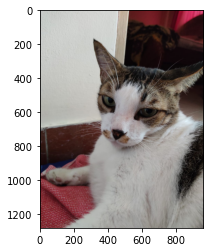

pepe.jpeg is a cat


In [16]:
import numpy as np
from tensorflow.keras.preprocessing import image


img=image.load_img(path_file_test, target_size=(150, 150))
x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
  
classes = model.predict(images, batch_size=10)

img = mpimg.imread(path_file_test)
imgplot = plt.imshow(img)
plt.show()

#print(classes[0])
if classes[0]>0:
    print(fn + " is a dog")    
else:
    print(fn + " is a cat")


### Visualizing representations

Pick a random cat or dog image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

/home/moofarry/miniconda3/envs/tfcpu/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


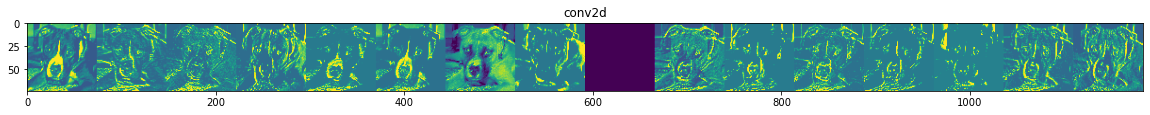

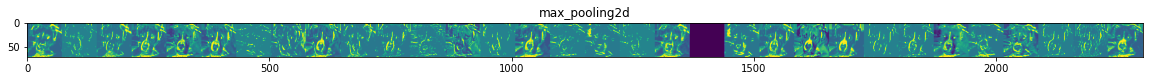

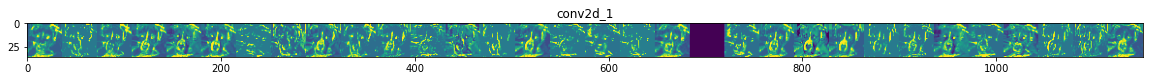

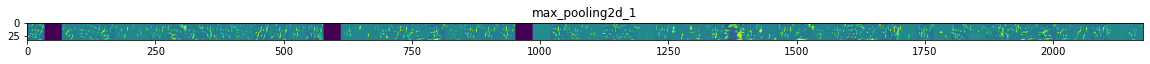

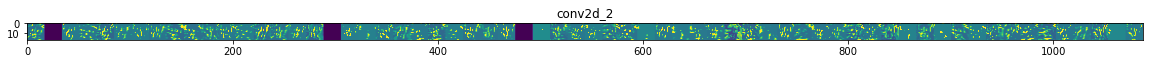

In [17]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

Texto original
we go from the raw pixels of the images to increasingly abstract and compact representations. 
The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.

These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image


### Evaluating Accuracy and Loss for the Model

Now, plot the training/validation accuracy and loss as collected during training:


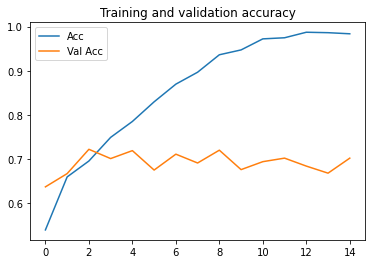

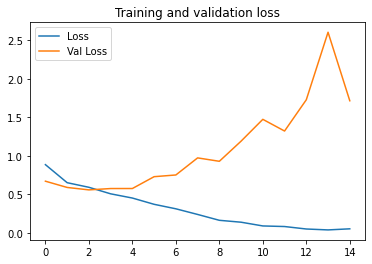

In [18]:
# Retrieve a list of list results on training and test data
# sets for each training epoch

#history is the name of the model
acc      = history.history[ 'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[ 'loss' ]
val_loss = history.history[ 'val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot  ( epochs,     acc , label= 'Acc')
plt.plot  ( epochs, val_acc , label= 'Val Acc')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()


# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss , label = 'Loss')
plt.plot  ( epochs, val_loss , label='Val Loss')
plt.title ('Training and validation loss'   )
plt.legend()


Run the next cell to terminate the kerlen and free memory resources